In [1]:
import os
from urllib.request import urlretrieve
from keras.preprocessing.image import load_img, img_to_array
from keras.applications import vgg19
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.
/Users/a1900001.1/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
class TransferDefinition():

    def __init__(self, content_image_path, style_image_path, img_nrows=400):
        self.width, self.height = load_img(content_image_path).size
        self.img_nrows = img_nrows
        self.img_ncols = int(self.width * self.img_nrows / self.height)

    def preprocess_image(self, image_path):
        img = load_img(image_path, target_size=(self.img_nrows, self.img_ncols))
        img = img_to_array(img)
        img = np.expand_dims(img, axis=0)
        img = vgg19.preprocess_input(img)
        return img

    def deprocess_image(self, x):
        img = x.copy()
        img = img.reshape(self.img_nrows, self.img_ncols, 3)
        # Remove zero-center by mean pixel
        img[:, :, 0] += 103.939
        img[:, :, 1] += 116.779
        img[:, :, 2] += 123.68
        # "BGR"->"RGB"
        img = img[:, :, ::-1]
        img = np.clip(img, 0, 255).astype("uint8")
        return img

In [3]:
def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

In [4]:
def content_loss(content, combination):
    return K.sum(K.square(combination - content))

def style_loss(tdef, style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = tdef.img_nrows * tdef.img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def total_variation_loss(tdef, x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :tdef.img_nrows - 1, :tdef.img_ncols - 1, :] - x[:, 1:, :tdef.img_ncols - 1, :])  
    b = K.square(x[:, :tdef.img_nrows - 1, :tdef.img_ncols - 1, :] - x[:, :tdef.img_nrows - 1, 1:, :])  
    return K.sum(K.pow(a + b, 1.25))

In [5]:
def main(content_image_path, style_image_path, iter_count=10,
         content_weight=1.0, style_weight=0.1, total_variation_weight=0.001,
         learning_rate=0.001):
    tdef = TransferDefinition(content_image_path, style_image_path)

    # inputs
    content_image = K.variable(tdef.preprocess_image(content_image_path))
    style_image = K.variable(tdef.preprocess_image(style_image_path))
    # generated image
    combination_image = K.placeholder((1, tdef.img_nrows, tdef.img_ncols, 3))
    input_tensor = K.concatenate([content_image,
                                  style_image,
                                  combination_image], axis=0)

    # load pre-trained model
    model = vgg19.VGG19(input_tensor=input_tensor,
                        weights="imagenet", include_top=False)
    outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

    # define loss
    loss = K.variable(0.)
    feature_map = outputs_dict["block5_conv2"]
    feature_of_content = feature_map[0, :, :, :]
    feature_of_combination = feature_map[2, :, :, :]

    loss += content_weight * content_loss(
                                    feature_of_content,
                                    feature_of_combination)

    feature_layers = ["block1_conv1", "block2_conv1",
                      "block3_conv1", "block4_conv1",
                      "block5_conv1"]

    for layer_name in feature_layers:
        feature_map = outputs_dict[layer_name]
        feature_of_style = feature_map[1, :, :, :]
        feature_of_combination = feature_map[2, :, :, :]
        sl = style_loss(tdef, feature_of_style, feature_of_combination)
        loss += (style_weight / len(feature_layers)) * sl

    loss += total_variation_weight * total_variation_loss(tdef, combination_image)  
    grads = K.gradients(loss, combination_image)[0]
    style_transfer = K.function([combination_image], [loss, grads])

    image = tdef.preprocess_image(content_image_path)
    for i in range(iter_count):
        print("Start of iteration {}".format(i + 1))
        loss_value, grad_values = style_transfer([image])
        image -= grad_values * learning_rate

    fig = plt.figure(figsize=(10, 5))
    for kind in ["original", "style", "styled"]:
        if kind == "original":
            img = load_img(content_image_path,
                           target_size=(tdef.img_nrows, tdef.img_ncols))
            ax = plt.subplot(1, 3, 1)
        elif kind == "style":
            img = load_img(style_image_path,
                           target_size=(tdef.img_nrows, tdef.img_ncols))
            ax = plt.subplot(1, 3, 2)
        elif kind == "styled":
            img = tdef.deprocess_image(image)
            ax = plt.subplot(1, 3, 3)
        ax.set_title(kind)
        ax.imshow(img)
        ax.axis("off")

    plt.tight_layout()
    dir_name, file_name = os.path.split(content_image_path)
    file_root, ext = os.path.splitext(file_name)
    plt.savefig(os.path.join(dir_name, file_root + "_styled.png"))
    plt.show()

80142336/80134624 [==============================] - 26s 0us/step
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Start of iteration 1
Start of iteration 2
Start of iteration 3
Start of iteration 4
Start of iteration 5
Start of iteration 6
Start of iteration 7
Start of iteration 8
Start of iteration 9
Start of iteration 10


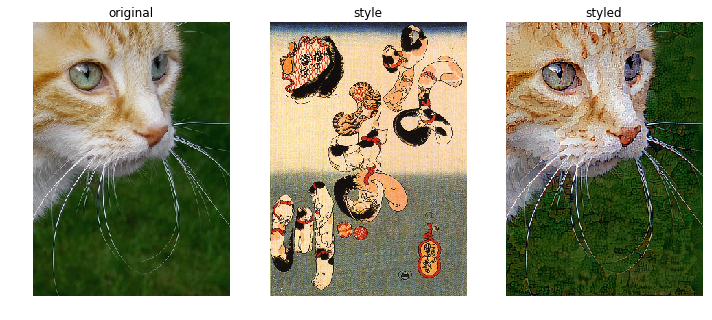

In [6]:
image_url = "http://farm2.static.flickr.com/1200/525304657_c59f741aac.jpg"
content_path = os.path.join(os.path.dirname('__file__'), "data/content.jpg")
urlretrieve(image_url, content_path)

image_url = "https://upload.wikimedia.org/wikipedia/commons/e/ed/Cats_forming_the_caracters_for_catfish.jpg"  # noqa
style_path = os.path.join(os.path.dirname('__file__'), "data/style.jpg")

urlretrieve(image_url, style_path)

main(content_path, style_path)